In [ ]:
# Part 1: Predict house prices based on square footage and location
# Data source:
# Kaggle - House Prices: Advanced Regression Techniques (train.csv)
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load real dataset (upload train.csv to Colab)
df = pd.read_csv("train.csv")

# Use "GrLivArea" as square footage and "Neighborhood" as location category
df = df[["SalePrice", "GrLivArea", "Neighborhood"]].dropna()

X = df[["GrLivArea", "Neighborhood"]].rename(columns={"GrLivArea": "square_footage", "Neighborhood": "location"})
y = df["SalePrice"]

# One-hot encode location, pass through square footage
preprocessor = ColumnTransformer(
    transformers=[
        ("location", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["location"])
    ],
    remainder="passthrough"
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predict: 2000 sq ft in a neighborhood (choose one that exists in dataset)
example_location = X["location"].mode()[0]  # most common neighborhood
new_house = pd.DataFrame({"square_footage": [2000], "location": [example_location]})
predicted_price = model.predict(new_house)[0]
print(f"Predicted price for a 2000 sq ft house in {example_location}: ${predicted_price:,.2f}")

# Coefficients
ohe = model.named_steps["preprocessor"].named_transformers_["location"]
loc_names = ohe.get_feature_names_out(["location"]).tolist()
feature_names = loc_names + ["square_footage"]

coefficients = model.named_steps["regressor"].coef_

print("\nModel Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.2f}")

# Interpretation (print-friendly for rubric)
sqft_coef = coefficients[-1]
print(f"\nInterpretation: Holding location constant, +1 sq ft changes price by about ${sqft_coef:,.2f}.")
print("Location coefficients shift price relative to the baseline location (the one not listed due to one-hot encoding).")


Predicted price for a 2000 sq ft house in NAmes: $199,439.21

Model Coefficients:
location_Blmngtn: 15916.57
location_Blueste: -36576.67
location_BrDale: -51780.44
location_BrkSide: -34350.03
location_ClearCr: 16301.31
location_CollgCr: 19492.68
location_Crawfor: 7062.28
location_Edwards: -40751.05
location_Gilbert: 2269.27
location_IDOTRR: -49248.61
location_MeadowV: -52983.05
location_Mitchel: -9646.37
location_NAmes: -20084.98
location_NPkVill: -17811.23
location_NWAmes: -9598.79
location_NoRidge: 70532.32
location_NridgHt: 97818.13
location_OldTown: -53131.10
location_SWISU: -62843.19
location_Sawyer: -22004.41
location_SawyerW: -4096.70
location_Somerst: 38318.51
location_StoneBr: 96251.05
location_Timber: 37058.39
location_Veenker: 63886.12
square_footage: 76.46

Interpretation: Holding location constant, +1 sq ft changes price by about $76.46.
Location coefficients shift price relative to the baseline location (the one not listed due to one-hot encoding).


In [ ]:
# Part 2: Predict Customer Churn (Logistic Regression)
# Data source:
# Kaggle - Telco Customer Churn (WA_Fn-UseC_-Telco-Customer-Churn.csv)
# https://www.kaggle.com/datasets/blastchar/telco-customer-churn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Target
df["churn"] = (df["Churn"] == "Yes").astype(int)

# Clean numeric column that may contain blanks
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])

# Features (feel free to expand)
X = df[["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen", "Contract", "InternetService", "PaymentMethod"]].copy()
y = df["churn"]

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols = ["Contract", "InternetService", "PaymentMethod"]
bin_cols = ["SeniorCitizen"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("bin", "passthrough", bin_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)

# Predict churn probability for a new customer (example)
new_customer = pd.DataFrame([{
    "tenure": 3,
    "MonthlyCharges": 85.0,
    "TotalCharges": 250.0,
    "SeniorCitizen": 0,
    "Contract": "Month-to-month",
    "InternetService": "Fiber optic",
    "PaymentMethod": "Electronic check"
}])

churn_probability = model.predict_proba(new_customer)[0][1]
threshold = 0.5
churn_prediction = 1 if churn_probability >= threshold else 0

print(f"Churn Probability for new customer: {churn_probability:.2f} ({churn_probability*100:.1f}%)")
print(f"Churn Prediction (1 = churn, 0 = no churn) with threshold {threshold}: {churn_prediction}")

# Coefficients (top drivers)
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefficients}).sort_values("coef", ascending=False)

print("\nTop churn-increasing features:")
print(coef_df.head(10).to_string(index=False))

print("\nTop churn-decreasing features:")
print(coef_df.tail(10).to_string(index=False))

print("\nInterpretation tip: Positive coefficients increase churn log-odds; negative decrease it (holding others constant).")


Churn Probability for new customer: 0.69 (69.2%)
Churn Prediction (1 = churn, 0 = no churn) with threshold 0.5: 1

Top churn-increasing features:
                                   feature      coef
          cat__InternetService_Fiber optic  0.925156
              cat__Contract_Month-to-month  0.820699
                         num__TotalCharges  0.677106
       cat__PaymentMethod_Electronic check  0.357826
                        bin__SeniorCitizen  0.345357
                  cat__InternetService_DSL -0.016231
                    cat__Contract_One year -0.039139
                       num__MonthlyCharges -0.089065
cat__PaymentMethod_Credit card (automatic) -0.094811
           cat__PaymentMethod_Mailed check -0.129903

Top churn-decreasing features:
                                     feature      coef
                          bin__SeniorCitizen  0.345357
                    cat__InternetService_DSL -0.016231
                      cat__Contract_One year -0.039139
                   

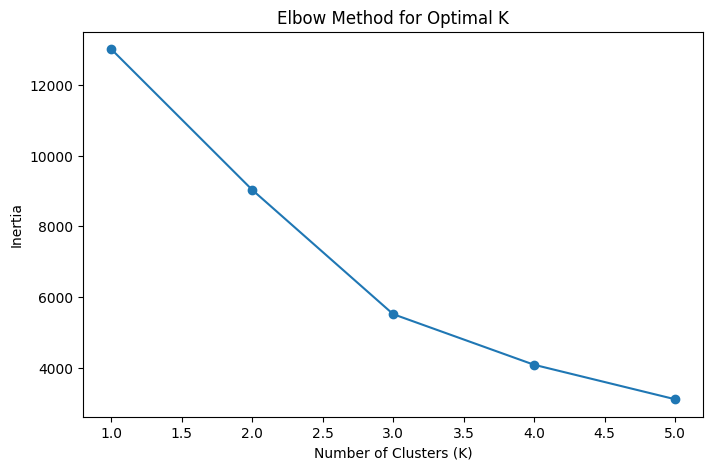

Cluster Characteristics:
         annual_spending  purchase_frequency  avg_item_price
cluster                                                     
0                1531.02                 3.9            4.00
1                2033.10                 1.0         2033.10
2               85581.36                64.0            3.99

Cluster 0 Strategy:
Low-engagement customers: reactivation offers, onboarding emails, personalized recommendations.

Cluster 1 Strategy:
Low-engagement customers: reactivation offers, onboarding emails, personalized recommendations.

Cluster 2 Strategy:
High-spending customers: offer VIP perks, exclusive bundles, early access promotions.

Saved: customer_segments.csv and elbow_plot.png


In [ ]:
# Part 3: Customer Segmentation (K-Means)
# Data source:
# UCI Machine Learning Repository - Online Retail (Online Retail.xlsx)
# https://archive.ics.uci.edu/dataset/352/online+retail

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load (upload Online Retail.xlsx to Colab)
df = pd.read_excel("Online Retail.xlsx")

# Basic cleaning
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df["TotalSpend"] = df["Quantity"] * df["UnitPrice"]

# Build customer-level segmentation table
cust = df.groupby("CustomerID").agg(
    annual_spending=("TotalSpend", "sum"),
    purchase_frequency=("InvoiceNo", "nunique"),
    avg_item_price=("UnitPrice", "mean")
).reset_index()

features = ["annual_spending", "purchase_frequency", "avg_item_price"]
X = cust[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method (K=1..5)
inertia = []
K = range(1, 6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K), inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.savefig("elbow_plot.png", dpi=150)
plt.show()

# Choose K (rubric wants you to justify; common choice is 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cust["cluster"] = kmeans.fit_predict(X_scaled)

# Cluster summary
cluster_summary = cust.groupby("cluster")[features].mean().round(2)
print("Cluster Characteristics:")
print(cluster_summary)

# Targeted strategies (simple rubric-friendly)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")
    if cluster_summary.loc[cluster, "annual_spending"] > cluster_summary["annual_spending"].median():
        print("High-spending customers: offer VIP perks, exclusive bundles, early access promotions.")
    elif cluster_summary.loc[cluster, "purchase_frequency"] > cluster_summary["purchase_frequency"].median():
        print("Frequent buyers: loyalty rewards, subscriptions, replenishment reminders.")
    else:
        print("Low-engagement customers: reactivation offers, onboarding emails, personalized recommendations.")

# Save cluster assignments
cust.to_csv("customer_segments.csv", index=False)
print("\nSaved: customer_segments.csv and elbow_plot.png")
